<a href="https://colab.research.google.com/github/cabroderick/AlgoHW2/blob/master/mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Testing Mask-RCNN on sample dataset provided from ME team**

In [ ]:
# fix package versions
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

In [ ]:
!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import repo and set up maskrcnn
%cd '/content/drive/MyDrive/'
!git clone https://github.com/matterport/Mask_RCNN.git
%cd Mask_RCNN/
!python setup.py install
!pip show mask-rcnn

In [54]:
# imports
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import os
import json

In [15]:
# list data contents
%cd /content/drive/MyDrive/MQP/Trial/H6
!ls . 
%cd '/content/drive/MyDrive/MQP/Trial/Labeled H6'
!ls .

/content/drive/MyDrive/MQP/Trial/H6
A1H6COL_10X_BF_ZUYL_11.tif     A1H6COL_10X_BF_ZUYL_22.tif
A1H6COL_10X_BF_ZUYL_12.tif     A1H6COL_10X_BF_ZUYL_23.tif
A1H6COL_10X_BF_ZUYL_13.tif     A1H6COL_10X_BF_ZUYL_24.tif
A1H6COL_10X_BF_ZUYL_14.tif     A1H6COL_10X_BF_ZUYL_25.tif
A1H6COL_10X_BF_ZUYL_1.5.1.tif  A1H6COL_10X_BF_ZUYL_26.tif
A1H6COL_10X_BF_ZUYL_1.5.2.tif  A1H6COL_10X_BF_ZUYL_27.tif
A1H6COL_10X_BF_ZUYL_1.5.3.tif  A1H6COL_10X_BF_ZUYL_28.tif
A1H6COL_10X_BF_ZUYL_1.5.4.tif  A1H6COL_10X_BF_ZUYL_291.tif
A1H6COL_10X_BF_ZUYL_1.5.5.tif  A1H6COL_10X_BF_ZUYL_29.tif
A1H6COL_10X_BF_ZUYL_1.5.6.tif  A1H6COL_10X_BF_ZUYL_31.tif
A1H6COL_10X_BF_ZUYL_1.5.7.tif  A1H6COL_10X_BF_ZUYL_32.tif
A1H6COL_10X_BF_ZUYL_1.5.8.tif  A1H6COL_10X_BF_ZUYL_33.tif
A1H6COL_10X_BF_ZUYL_1.5.9.tif  A1H6COL_10X_BF_ZUYL_34.tif
A1H6COL_10X_BF_ZUYL_15.tif     A1H6COL_10X_BF_ZUYL_35.tif
A1H6COL_10X_BF_ZUYL_16.tif     A1H6COL_10X_BF_ZUYL_36.tif
A1H6COL_10X_BF_ZUYL_17.tif     A1H6COL_10X_BF_ZUYL_37.tif
A1H6COL_10X_BF_ZUYL_18.tif     A1H6

In [ ]:
# config network
class CustomConfig(Config):
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CustomConfig()
config.display()

In [66]:
# set up dataset
class AMDataset(utils.Dataset):
  def load_dataset(self):
    IMAGES_DIR = '/content/drive/MyDrive/MQP/Trial/H6'
    ANNOTATIONS_DIR = '/content/drive/MyDrive/MQP/Trial/Labeled H6'

    self.add_class('dataset', 1, 'gas porosity')
    self.add_class('dataset', 2, 'lack of fusion porosity')

    for filename in os.listdir(IMAGES_DIR):
      image_id = filename[:-4]
      image_path = IMAGES_DIR + image_id + '.tif'
      annotation_path = ANNOTATIONS_DIR + image_id + '_labeled.json'
      self.add_image('dataset', image_id=image_id, path=image_path, annotation=annotation_path)

  def load_mask(self, image_id):
      pass

  def parse_json(self, filename): # helper to extract bounding boxes from json
      f = open(filename,)
      data = json.load(f)

      boxes = {'gas porosity': [], 'lack of fusion porosity': []}

      for i in data['shapes']:
        label = i['label']
        print(label)

        if len(i['points']) != 4:
          pass # only want to deal with bounding boxes for now
        coords = []
        for coord in i['points']:
          [coords.append(x) for x in coord if x not in coords]

dataset_train = AMDataset()
AMDataset.load_dataset(dataset_train)
AMDataset.parse_json(dataset_train, '/content/drive/MyDrive/MQP/Trial/Labeled H6/A1H6COL_10X_BF_ZUYL_1.5.1_labeled.json')
#TODO: train-test-split

lack of fusion porosity
gas porosity
lack of fusion porosity
lack of fusion porosity
gas porosity
gas porosity
lack of fusion porosity


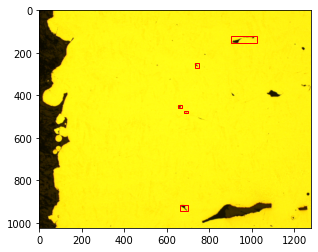

In [ ]:

# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()
 
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80
 
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('mask_rcnn_coco.h5', by_name=True)
# load photograph
img = load_img('img.tif')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes('img.tif', results[0]['rois'])

In [ ]:
def 